Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
import pickle
import time
import seaborn as sns

PUNTO 2: EDA

1. Leer CSV

In [2]:
df_available = pd.read_csv("attrition_availabledata_03.csv")

2. Calculando el número de variables e instancias

In [3]:
print("\n🔹 Número de instancias y variables:")
print(f"Filas: {df_available.shape[0]}, Columnas: {df_available.shape[1]}")


🔹 Número de instancias y variables:
Filas: 2940, Columnas: 31


3. Identificando todos los tipos de variables (Categóricas, numéricas y ordinales)

In [4]:
col_categoricas = df_available.select_dtypes(include=['object']).columns.tolist()
col_numericas = df_available.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\n🔹 Variables categóricas:", col_categoricas)
print("\n🔹 Nº variables categóricas: " , len(col_categoricas))
print("🔹 Variables numéricas:", col_numericas)
print("\n🔹 Nº variables numéricas: " , len(col_numericas))


🔹 Variables categóricas: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']

🔹 Nº variables categóricas:  8
🔹 Variables numéricas: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

🔹 Nº variables numéricas:  23


4. Clasificación de todas las variables segun su cardinalidad

    Consideramos alta cardinalidas a variables con mas de 5 posibles valores

In [5]:
col_cardinalidad_alta = [col for col in col_categoricas if df_available[col].nunique() > 5]
print("\n🔹 Variables categóricas con alta cardinalidad:", col_cardinalidad_alta)


🔹 Variables categóricas con alta cardinalidad: ['EducationField', 'JobRole']


5. Identificación de las variables que tienen valor nulo

In [6]:
valores_nulos = df_available.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0]
print("\n🔹 Valores nulos por columna:")
print(valores_nulos)


🔹 Valores nulos por columna:
EnvironmentSatisfaction    15
JobSatisfaction            12
WorkLifeBalance            21
NumCompaniesWorked         13
TotalWorkingYears           6
dtype: int64


6. Detección de las columnas constantes de un solo valor

In [7]:
col_constantes = [col for col in df_available.columns if df_available[col].nunique() == 1]
print("\n🔹 Columnas constantes (sin variabilidad):", col_constantes)


🔹 Columnas constantes (sin variabilidad): ['EmployeeCount', 'Over18', 'StandardHours']


7. Detección de columnas binarias

In [8]:
col_binarias = [col for col in df_available.columns if df_available[col].nunique() == 2]
print("\n🔹 Columnas binarias:", col_binarias)


🔹 Columnas binarias: ['PerformanceRating', 'Gender', 'Attrition']


8. Identificando columnas de identificación

In [9]:
id_cols = [col for col in df_available.columns if "ID" in col or "id" in col or "EmployeeCount" in col]
print("\n🔹 Posibles columnas de ID:", id_cols)


🔹 Posibles columnas de ID: ['EmployeeCount', 'EmployeeID']


10. Análisis del desbalanceo de "Attrition"

10.1. Primero hacemos un análisis del tipo de problema con el que estamos tratando

In [10]:
target_col = "Attrition"
if df_available[target_col].dtype == 'object' or df_available[target_col].nunique() <= 10:
    print("\n🔹 Es un problema de CLASIFICACIÓN.")
else:
    print("\n🔹 Es un problema de REGRESIÓN.")


🔹 Es un problema de CLASIFICACIÓN.


10.2. Si es un problema de clasificación hacemos un análisis del desbalanceo de la variable objetivo

In [11]:
attrition_distribution = df_available[target_col].value_counts(normalize=True) * 100
print("\n🔹 Distribución de la variable objetivo (absences):")
print(attrition_distribution)


🔹 Distribución de la variable objetivo (absences):
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


10.3. Generando la visualización del desbalanceo

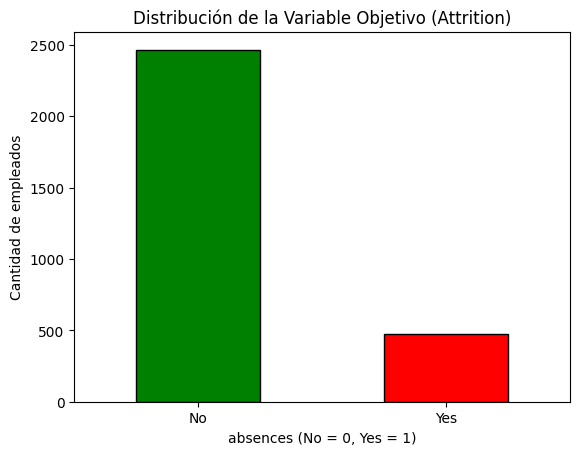

In [12]:
df_available["Attrition"].value_counts().plot(kind='bar', color=['green', 'red'], edgecolor="black")
plt.title("Distribución de la Variable Objetivo (Attrition)")
plt.ylabel("Cantidad de empleados")
plt.xlabel("absences (No = 0, Yes = 1)")
plt.xticks(rotation=0)
plt.show()

Conclusiones:

Se puede ver que hay un gran desbalanceo de clases de hasta 5 veces menos instancias para el valor "Yes"

---------------------------------------------------------------------

PUNTO 3: CROSS VALIDATION

1. Eliminación de datos irrelevantes

    Estas columnas son identificadores "EmployeeID" y valores constantes

In [13]:
# Eliminar columnas irrelevantes
drop_columns = ["EmployeeID", "Over18", "StandardHours", "EmployeeCount"]
df = df_available.drop(columns=drop_columns, errors='ignore')

2. Convertir todas las variables a tipo numérico y separar según características y variable objetivo (Attrition)

In [14]:
# Convertir variables categóricas a numéricas usando Label Encoding
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Guardar para futuras conversiones si es necesario

# Separar en características (X) y variable objetivo (y)
X = df.drop(columns=["Attrition"])
y = df["Attrition"]

3. Preprocesamiento de datos: detección de outliers y escalado

3.1. Seleccionando columnas numéricas

In [15]:
df = X

numerical_cols = df.select_dtypes(include=
[np.number]).columns.tolist()

3.2. Función para detectar outliers usando regla IQR

In [16]:
def porcentaje_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    # Definir límites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((col < lower_bound) | (col > upper_bound)).sum()
    return outlier_count / len(col)

3.3. Definiendo umbrales para la recomendación
    
    - Si la asimentría es mayor a 1 o menor a -1 se considera alta asimetría
    - Si más del 5% de las instancias son outliers

In [17]:
umbral_skew = 1.0
umbral_out = 0.05

print("Recomendación de transformación para cada columna numérica:")
print("-" * 70)

robust_columns = []
standard_columns = []

for col in numerical_cols:
    serie = df[col]
    skew = serie.skew()
    outlier_pct = porcentaje_outliers(serie)
    desc = serie.describe()
    
    print(f"\nColumna: {col}")
    print(f"  Media: {desc['mean']:.3f}, Std: {desc['std']:.3f}")
    print(f"  Mín: {desc['min']}, Máx: {desc['max']:.3f}")
    print(f"  Asimetría (skew): {skew:.3f}")
    print(f"  Porcentaje de outliers (IQR): {outlier_pct*100:.2f}%")
    
    # Lógica de recomendación
    if abs(skew) > umbral_skew or outlier_pct > umbral_out:
        robust_columns.append(col)
        print("  -> Sugerencia: La distribución es sesgada y/o presenta outliers; se recomienda normalización o escalado robusto.")
    else:
        standard_columns.append(col)
        print("  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.")

Recomendación de transformación para cada columna numérica:
----------------------------------------------------------------------

Columna: hrs
  Media: 7.326, Std: 1.334
  Mín: 5.4168797411869445, Máx: 10.937
  Asimetría (skew): 0.859
  Porcentaje de outliers (IQR): 2.62%
  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.

Columna: absences
  Media: 12.702, Std: 5.518
  Mín: 1.0, Máx: 24.000
  Asimetría (skew): 0.015
  Porcentaje de outliers (IQR): 0.00%
  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.

Columna: JobInvolvement
  Media: 2.740, Std: 0.718
  Mín: 1.0, Máx: 4.000
  Asimetría (skew): -0.516
  Porcentaje de outliers (IQR): 0.00%
  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.

Columna: PerformanceRating
  Media: 3.161, Std: 0.367
  Mín: 3.0, Máx: 4.000
  Asimetría (skew): 1.847
  Porcentaje de outliers (IQR): 16

3.4. Intanciación y aplicación de escaladores

In [18]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

# Aplicar las transformaciones de forma separada
X_transformed = X.copy()

if robust_columns:
    X_transformed[robust_columns] = robust_scaler.fit_transform(X[robust_columns])
if standard_columns:
    X_transformed[standard_columns] = standard_scaler.fit_transform(X[standard_columns])

4. Division de datos y configuración de Cross-Validation

    Se usa el parametro stratify para mantener la proporción de clases en Train y Test. Debido al desbalanceo de clases que se vio en el EDA.

In [19]:
# Dividir en Train (2/3) y Test (1/3)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=1/3, random_state=3, stratify=y)

# Evaluación INNER: K-Fold Cross Validation (k=5)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

print("Datos preparados: Train (2/3), Test (1/3), y Cross-Validation lista.")


Datos preparados: Train (2/3), Test (1/3), y Cross-Validation lista.


5. Evaluación outer: Estimación de rendimiento con un modelo base

In [20]:
# Entrenar modelo base en Train
model = DecisionTreeClassifier(random_state=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=3)

In [21]:
# Predecir en el conjunto de Test (Outer Evaluation)
y_pred = model.predict(X_test)

In [22]:
# Cálculo de métricas
balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [23]:
# Matriz de confusión para obtener TPR y TNR
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

In [24]:
# True Positive Rate (TPR) y True Negative Rate (TNR)
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)

# 📌 Mostrar resultados
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
print(f"Matriz de Confusión:\n{conf_matrix}")

Balanced Accuracy: 0.8580
Accuracy: 0.9204
True Positive Rate (TPR): 0.7658
True Negative Rate (TNR): 0.9501
Matriz de Confusión:
[[781  41]
 [ 37 121]]


5. HPO

In [25]:
# Definir el espacio de hiperparámetros a optimizar
param_grid = {
    'criterion': ['gini', 'entropy'],               # Función de evaluación para medir la calidad del split
    'max_depth': [3, 5, 7, None],                     # Profundidad máxima del árbol para controlar la complejidad
    'min_samples_split': [2, 5, 10],                  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],                    # Mínimo número de muestras en una hoja para evitar hojas con pocos ejemplos
    'max_features': [None, 'sqrt', 'log2'],           # Número de variables a considerar en cada división
    'class_weight': [None, 'balanced']                # Ajuste de pesos para mitigar el desbalance de clases
}

# Usar el mismo kfold definido para la evaluación inner
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=3),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=kfold,  # Evaluación inner con validación cruzada estratificada (k=5)
    n_jobs=-1
)

# Ajustar en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y la métrica de inner evaluation
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Puntuación inner (Balanced Accuracy):", grid_search.best_score_)


Mejores hiperparámetros: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Puntuación inner (Balanced Accuracy): 0.8076136239610875


Explicacion de los hipermetros modificados:

Añadir

--------------------------------------------------------------------------------------

PUNTO 4: MÉTODOS BÁSICOS (KNN y Árboles de decisión)

1. Escalar e imputar usando KNN como referencia

In [26]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

imputers = {
    "Mean": SimpleImputer(strategy="mean"),
    "Median": SimpleImputer(strategy="median")
}

2. Evaluando con KNN y árboles de decisión

In [ ]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)
best_score = 0
best_scaler = None
best_imputer = None
best_score_tree = 0
best_scaler_tree = None
best_imputer_tree = None

for scaler_name, scaler in scalers.items():
    for imputer_name, imputer in imputers.items():
        X_train_imputed = imputer.fit_transform(X_train)
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        
        knn = KNeighborsClassifier(n_neighbors=5)
        score = np.mean(cross_val_score(knn, X_train_scaled, y_train, cv=kfold, scoring="balanced_accuracy"))
        
        print(f"Scaler: {scaler_name}, Imputer: {imputer_name}, Score: {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_scaler = scaler
            best_imputer = imputer
        # Para arboles de decisión
        tree_= DecisionTreeClassifier(random_state=3)
        score_tree = np.mean(cross_val_score(tree_, X_train_scaled, y_train, cv=kfold, scoring="balanced_accuracy"))
        
        print(f"Scaler: {scaler_name}, Imputer: {imputer_name}, Score (Tree): {score_tree:.4f}")
        
        if score_tree > best_score_tree:
            best_score_tree = score_tree
            best_scaler_tree = scaler
            best_imputer_tree = imputer

print("\nMejor combinación de scaler e imputer para KNN:")
print(f"Scaler: {best_scaler.__class__.__name__}, Imputer: {best_imputer.strategy}, Score: {best_score:.4f}")
print("\nMejor combinación de scaler e imputer para Decision Tree:")
print(f"Scaler: {best_scaler_tree.__class__.__name__}, Imputer: {best_imputer_tree.strategy}, Score: {best_score_tree:.4f}")

# Imprimir el mejor imputer strategy
print("Mejor estrategia de imputación:", best_imputer_tree.strategy)

Scaler: StandardScaler, Imputer: Mean, Score: 0.5928
Scaler: StandardScaler, Imputer: Mean, Score (Tree): 0.7788
Scaler: StandardScaler, Imputer: Median, Score: 0.5928
Scaler: StandardScaler, Imputer: Median, Score (Tree): 0.7806
Scaler: MinMaxScaler, Imputer: Mean, Score: 0.5912
Scaler: MinMaxScaler, Imputer: Mean, Score (Tree): 0.7793
Scaler: MinMaxScaler, Imputer: Median, Score: 0.5899
Scaler: MinMaxScaler, Imputer: Median, Score (Tree): 0.7805
Scaler: RobustScaler, Imputer: Mean, Score: 0.5968
Scaler: RobustScaler, Imputer: Mean, Score (Tree): 0.7788
Scaler: RobustScaler, Imputer: Median, Score: 0.5962
Scaler: RobustScaler, Imputer: Median, Score (Tree): 0.7800

Mejor combinación de scaler e imputer para KNN:
Scaler: RobustScaler, Imputer: mean, Score: 0.5968

Mejor combinación de scaler e imputer para Decision Tree:
Scaler: StandardScaler, Imputer: median, Score: 0.7806
Mejor estrategia de imputación: median


5. Optimización de hiperparámetros (HPO) con GridSearchCV

In [28]:
# Definir los grids de hiperparámetros
tree_params = {
    'criterion': ['gini', 'entropy'],               # Función de evaluación del split
    'max_depth': [3, 5, 7, None],                     # Profundidad máxima para controlar la complejidad
    'min_samples_split': [2, 5, 10],                  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],                    # Mínimo número de muestras en una hoja
    'max_features': [None, 'sqrt', 'log2'],           # Número de variables a considerar en cada división
    'class_weight': [None, 'balanced']                # Ajuste de pesos para mitigar el desbalance de clases
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9],                      # Número de vecinos: controla el sesgo/varianza
    'weights': ['uniform', 'distance'],               # Tipo de ponderación de los vecinos
    'metric': ['euclidean', 'manhattan']              # Métrica de distancia
}

# Definir la validación cruzada repetida: 5 splits, 10 repeticiones: COMENTAR LUEGO ESTA DECISION
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)

# Optimización con GridSearchCV para KNeighborsClassifier
knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    scoring='balanced_accuracy',
    cv=rskf,       # Validación cruzada repetida
    n_jobs=-1
)

# Optimización con GridSearchCV para DecisionTreeClassifier
tree_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=3),
    param_grid=tree_params,
    scoring='balanced_accuracy',
    cv=rskf,       # Validación cruzada repetida
    n_jobs=-1
)

# Entrenamos GridSearchCV en el conjunto de entrenamiento escalado
knn_grid.fit(X_train_scaled, y_train)
tree_grid.fit(X_train_scaled, y_train)

# Imprimir todos los scores probados para KNeighborsClassifier
# print("Resultados para KNeighborsClassifier:")
# for score, params in zip(knn_grid.cv_results_['mean_test_score'], knn_grid.cv_results_['params']):
#     print(f"Parámetros: {params}, Balanced Accuracy: {score:.4f}")

# # Imprimir todos los scores probados para DecisionTreeClassifier
# print("\nResultados para DecisionTreeClassifier:")
# for score, params in zip(tree_grid.cv_results_['mean_test_score'], tree_grid.cv_results_['params']):
#     print(f"Parámetros: {params}, Balanced Accuracy: {score:.4f}")

# Mostrar el mejor resultado obtenido para cada modelo
print(f"\nMejor KNN: {knn_grid.best_params_}, Balanced Accuracy: {knn_grid.best_score_:.4f}")
print(f"Mejor Árbol: {tree_grid.best_params_}, Balanced Accuracy: {tree_grid.best_score_:.4f}")



Mejor KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}, Balanced Accuracy: 0.8162
Mejor Árbol: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, Balanced Accuracy: 0.7822


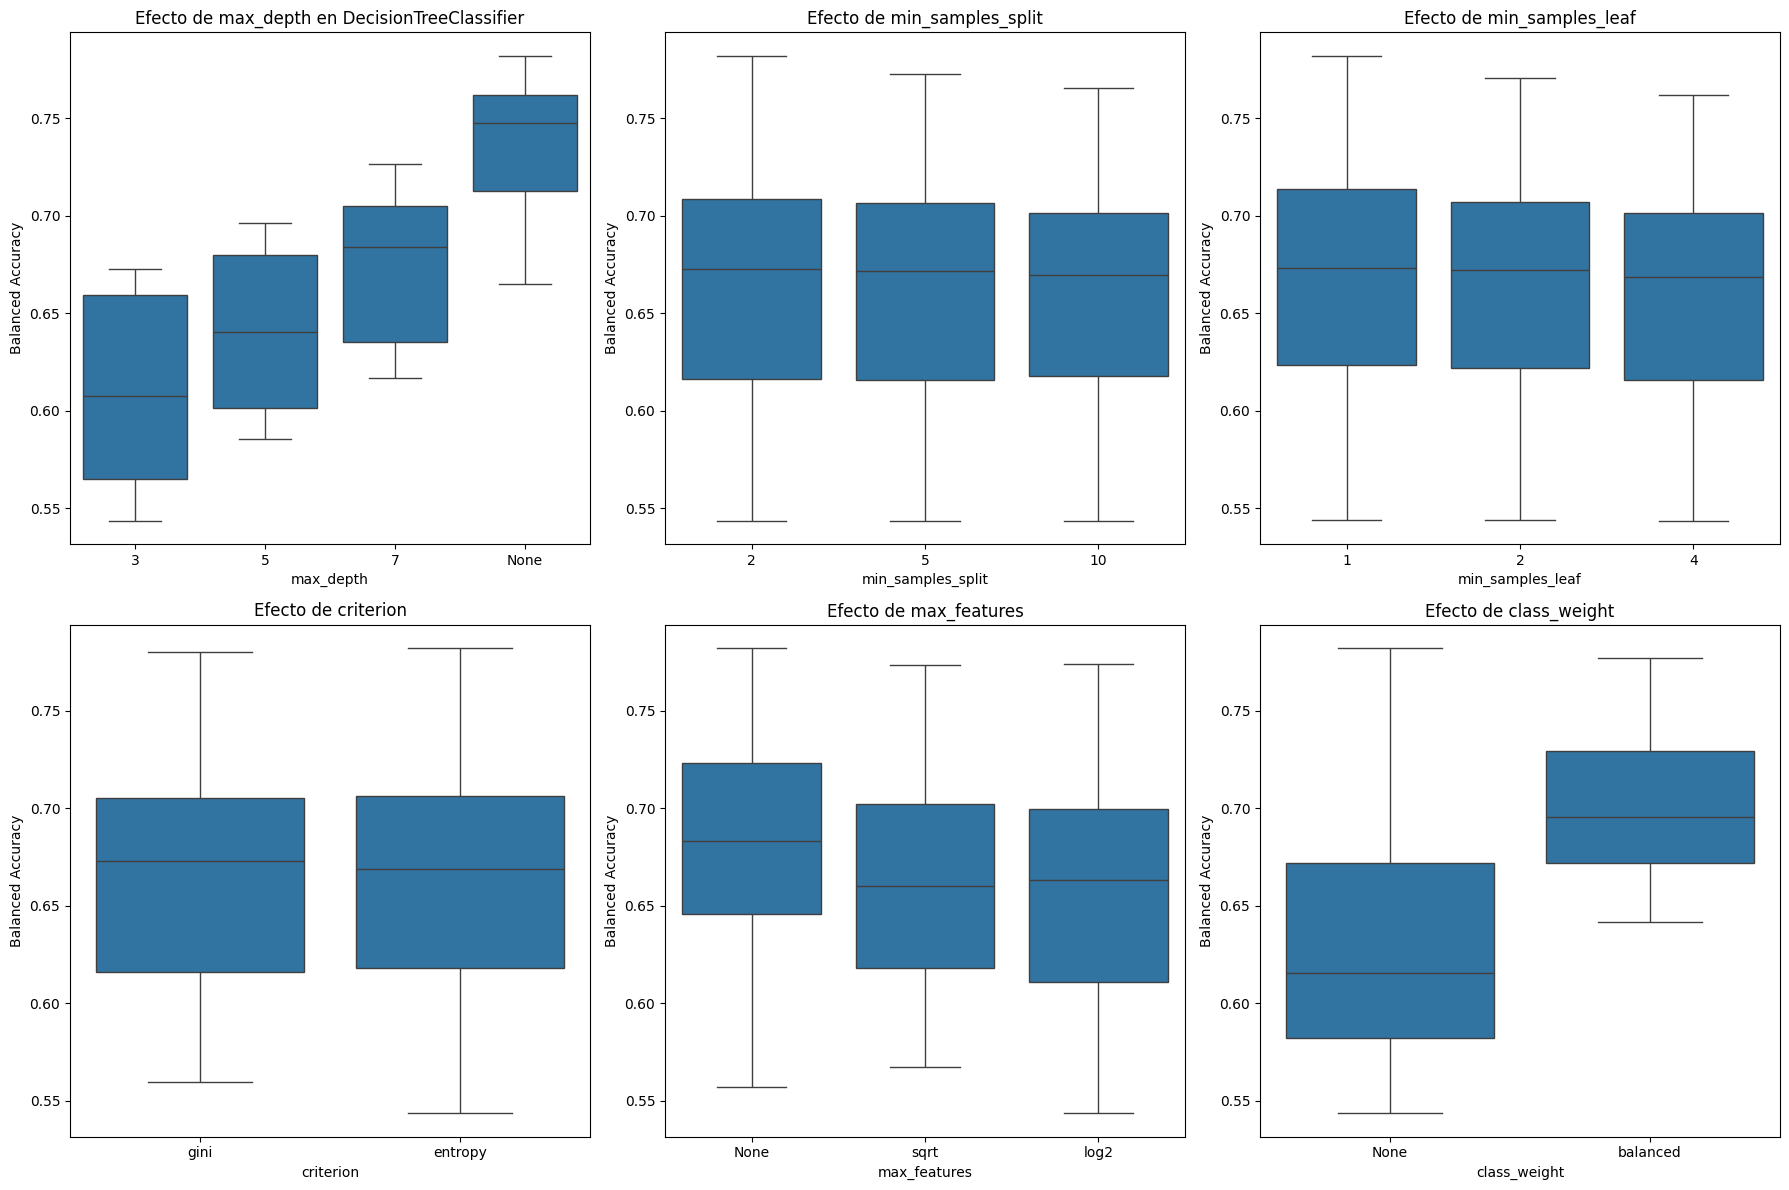

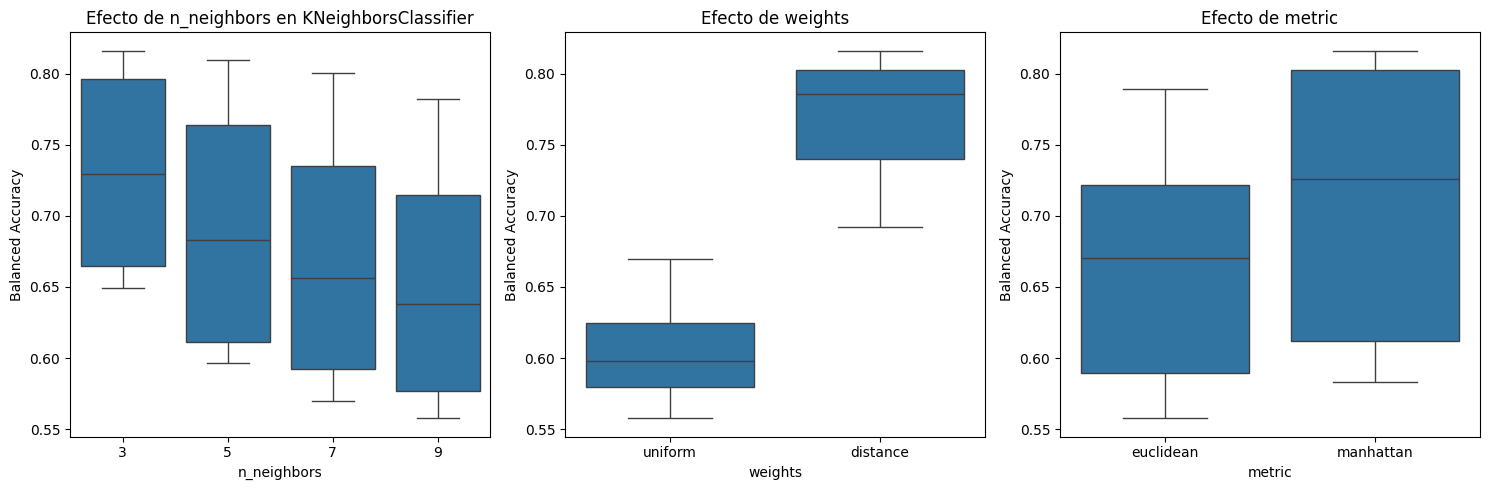

In [29]:
# Convertir cv_results_ a DataFrame para cada modelo
tree_results = pd.DataFrame(tree_grid.cv_results_)
knn_results = pd.DataFrame(knn_grid.cv_results_)

# Para facilitar la visualización, convertimos algunos hiperparámetros a string
tree_results['param_max_depth_str'] = tree_results['param_max_depth'].astype(str)
tree_results['param_min_samples_split_str'] = tree_results['param_min_samples_split'].astype(str)
tree_results['param_min_samples_leaf_str'] = tree_results['param_min_samples_leaf'].astype(str)
tree_results['param_criterion_str'] = tree_results['param_criterion'].astype(str)
tree_results['param_max_features_str'] = tree_results['param_max_features'].astype(str)
tree_results['param_class_weight_str'] = tree_results['param_class_weight'].astype(str)

knn_results['param_n_neighbors_str'] = knn_results['param_n_neighbors'].astype(str)
knn_results['param_weights_str'] = knn_results['param_weights'].astype(str)
knn_results['param_metric_str'] = knn_results['param_metric'].astype(str)

# -----------------------------
# Plots para DecisionTreeClassifier
# -----------------------------
plt.figure(figsize=(18, 12))

# Efecto de max_depth
plt.subplot(2, 3, 1)
sns.boxplot(x='param_max_depth_str', y='mean_test_score', data=tree_results)
plt.title('Efecto de max_depth en DecisionTreeClassifier')
plt.xlabel('max_depth')
plt.ylabel('Balanced Accuracy')

# Efecto de min_samples_split
plt.subplot(2, 3, 2)
sns.boxplot(x='param_min_samples_split_str', y='mean_test_score', data=tree_results)
plt.title('Efecto de min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('Balanced Accuracy')

# Efecto de min_samples_leaf
plt.subplot(2, 3, 3)
sns.boxplot(x='param_min_samples_leaf_str', y='mean_test_score', data=tree_results)
plt.title('Efecto de min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('Balanced Accuracy')

# Efecto de criterion
plt.subplot(2, 3, 4)
sns.boxplot(x='param_criterion_str', y='mean_test_score', data=tree_results)
plt.title('Efecto de criterion')
plt.xlabel('criterion')
plt.ylabel('Balanced Accuracy')

# Efecto de max_features
plt.subplot(2, 3, 5)
sns.boxplot(x='param_max_features_str', y='mean_test_score', data=tree_results)
plt.title('Efecto de max_features')
plt.xlabel('max_features')
plt.ylabel('Balanced Accuracy')

# Efecto de class_weight
plt.subplot(2, 3, 6)
sns.boxplot(x='param_class_weight_str', y='mean_test_score', data=tree_results)
plt.title('Efecto de class_weight')
plt.xlabel('class_weight')
plt.ylabel('Balanced Accuracy')

plt.tight_layout()
plt.show()

# -----------------------------
# Plots para KNeighborsClassifier
# -----------------------------
plt.figure(figsize=(15, 5))

# Efecto de n_neighbors
plt.subplot(1, 3, 1)
sns.boxplot(x='param_n_neighbors_str', y='mean_test_score', data=knn_results)
plt.title('Efecto de n_neighbors en KNeighborsClassifier')
plt.xlabel('n_neighbors')
plt.ylabel('Balanced Accuracy')

# Efecto de weights
plt.subplot(1, 3, 2)
sns.boxplot(x='param_weights_str', y='mean_test_score', data=knn_results)
plt.title('Efecto de weights')
plt.xlabel('weights')
plt.ylabel('Balanced Accuracy')

# Efecto de metric
plt.subplot(1, 3, 3)
sns.boxplot(x='param_metric_str', y='mean_test_score', data=knn_results)
plt.title('Efecto de metric')
plt.xlabel('metric')
plt.ylabel('Balanced Accuracy')

plt.tight_layout()
plt.show()


6. Evaluación final en el conjunto de Test (Outer)

In [31]:
# predecimos y evaluamos
best_knn = knn_grid.best_estimator_
best_tree = tree_grid.best_estimator_

X_train_imputed = best_imputer.fit_transform(X_train)
X_test_imputed = best_imputer.transform(X_test)
X_train_scaled = best_scaler.fit_transform(X_train_imputed)
X_test_scaled = best_scaler.transform(X_test_imputed)

y_pred_knn = best_knn.predict(X_test_scaled)
y_pred_tree = best_tree.predict(X_test_scaled)

# Métricas para cada modelo
def evaluar_modelo(y_test, y_pred, model_name):
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    TPR = tp / (tp + fn)
    TNR = tn / (tn + fp)
    
    print(f"\n{model_name} - Evaluación en Test Set")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate (TPR): {TPR:.4f}")
    print(f"True Negative Rate (TNR): {TNR:.4f}")
    print(f"Matriz de Confusión:\n{conf_matrix}")

evaluar_modelo(y_test, y_pred_knn, "KNN")
evaluar_modelo(y_test, y_pred_tree, "Árbol de Decisión")


KNN - Evaluación en Test Set
Balanced Accuracy: 0.8858
Accuracy: 0.9500
True Positive Rate (TPR): 0.7911
True Negative Rate (TNR): 0.9805
Matriz de Confusión:
[[806  16]
 [ 33 125]]

Árbol de Decisión - Evaluación en Test Set
Balanced Accuracy: 0.8456
Accuracy: 0.9082
True Positive Rate (TPR): 0.7532
True Negative Rate (TNR): 0.9380
Matriz de Confusión:
[[771  51]
 [ 39 119]]


-------------------------------------------

PUNTO 5: MÉTODOS AVANZADOS (MÉTODOS LINEALES Y SVMs)

1. Preparando datos de la variable objetivo (Attrition) para ser procesada

In [ ]:
X_procesado = df_available.drop("Attrition", axis=1)
Y_procesado = df_available["Attrition"].map({"Yes": 1, "No": 0})

2. Identificación de columnas categóricas y numéricas

In [ ]:
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

3. Eliminando columnas irrelevantes (ID y constantes)

In [ ]:
irrelevant = ["EmployeeID", "EmployeeCount", "Over18", "StandardHours"]
num_cols = [col for col in num_cols if col not in irrelevant]
cat_cols = [col for col in cat_cols if col not in irrelevant]
X_procesado = X_procesado.drop(columns=irrelevant)

4. Preprocesando todos los datos

In [ ]:
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

5. Modelos

In [ ]:
models = {
    "LogReg (default)": LogisticRegression(max_iter=1000, random_state=3),
    "LogReg (L1)": LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000, random_state=3),
    "SVM (linear)": SVC(kernel="linear", random_state=3),
    "SVM (rbf)": SVC(kernel="rbf", random_state=3)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", model)
    ])
    start = time.time()
    pipe.fit(X_train, y_train)
    end = time.time()
    y_pred = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results[name] = {
        "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "TPR": tp / (tp + fn),
        "TNR": tn / (tn + fp),
        "Time (s)": end - start
    }

6. Resultados

In [ ]:
resultado_avanzado = pd.DataFrame(results).T
print("\nResultados de los modelos avanzados:")
print(resultado_avanzado)

7. Interpretación de resultados